We used https://fred.stlouisfed.org/ to download Canada's economic data that might play a role in Real Estate trends, price levels etc...
One can also use https://tradingeconomics.com/canada/interest-rate.

In the folder "Canadian Economy Data", you will find csv containing monthly data about unemployment, Central Bank real interest rates, CPI(inflation), 
M1 money supply, CAD-USD exchange rates.

The goal is to develop a correlation matrix for between all data to help us in our featurs selection for the Machine Learning model I plan to make.
Correlation as a statistical measure indicates the strength by which to two variables move together. Correlation can be positive/direct, negative/inverse or near 0, high correlation 
values -between a dependent variable and an independent variable- are of high significance in determining the output, finding high correlations between input and output values helps for in building more accurate and faster ML model. We must keep in mind that more features does not mean better accuracy, we shall avoid overfitting.

We use Pearson Correlation coefficient -r- to measure how strong is the correlation in each pair of continiuous variables in our merged dataframe -hpi_and_economydata_df-.
All data in each column are scaled and continuous, the samples of each variables are independent of each other and from reputable sources: statscan(Canadian Government) and 
stlouisfed.org. The correlation is calculated by dividing the covariance fo two variables by the product of their respective standard deviations.

Correlation, r, ranges from -1 to 1 and is interpreted as follows:
_the closer to 1, the stronger the correlation between two variables 
    _the close to 0, the weaker the correlation 
        _ r >= 0.75 is considered as a strong correlation and r <= -0.75 is considered as strong negative correlation (https://statisticsbyjim.com/basics/correlations/; 
        https://www.statology.org/what-is-a-strong-correlation/)


In [44]:
import pandas as pd

In [151]:
#Processing raw_material_index and building_material_indexes dataframes
from distutils.command.build import build


building_const_pi_df = pd.read_csv(r"C:\Users\hp\Desktop\Projects Coding\Affinity_Propagation_Canada_Real_Estate_Market\Real Estate Data\18100135-eng\BuildingConstructionPriceIndex_BCPI_18100135.csv")

# type_of_buldings = building_const_pi_df["Type of building"].unique()
# print(type_of_buldings)

type_building_to_drop = ['Non-residential buildings [622]', 'Commercial buildings [62212]', 'Office building', 'Warehouse', 'Shopping centre', 'Industrial buildings [62211]', 
                        'Factory', 'Bus depot with maintenance and repair facilities', 'Institutional buildings [62213]', 'School']

#Removing rows that include strings in type_building_to_drop to maitain only buildings of interest.
building_const_pi_df = building_const_pi_df[~building_const_pi_df['Type of building'].isin(['Non-residential buildings [622]', 'Commercial buildings [62212]', 'Office building', 'Warehouse', 'Shopping centre', 
                        'Industrial buildings [62211]', 'Factory', 'Bus depot with maintenance and repair facilities', 'Institutional buildings [62213]', 'School'])]

#Removing irrelevant GEO locations, we want to keep Cities
building_const_pi_df = building_const_pi_df[~building_const_pi_df['GEO'].isin(['Eleven census metropolitan area composite'])]
building_const_pi_df
#Dropping irrelevant rows such as Symbols, status, vector...
building_const_pi_df = building_const_pi_df.drop(columns=['DGUID','SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE','STATUS','SYMBOL','TERMINATED', 'UOM_ID','DECIMALS'], axis = 1)
building_const_pi_df.head(100)


building_const_pi_df.tail()

# firstval = building_const_pi_df.VALUE.notna().idxmax()
#First non NAN in VALUE column at index = 5410

building_const_pi_df = building_const_pi_df.truncate(before = 5410)
building_const_pi_df.reset_index()
# building_const_pi_df.drop(columns=["index"], inplace = True, axis = 1)
building_const_pi_df

,REF_DATE,GEO,Type of building,UOM,VALUE
5410,1988-01,"Halifax, Nova Scotia",High-rise apartment building (five or more sto...,"Index, 2017=100",55.4
5411,1988-01,"Halifax, Nova Scotia",Low-rise apartment building (fewer than five s...,"Index, 2017=100",NaN
5412,1988-01,"Halifax, Nova Scotia",Single-detached house,"Index, 2017=100",NaN
5413,1988-01,"Halifax, Nova Scotia",Townhouse,"Index, 2017=100",NaN
5424,1988-01,"Moncton, New Brunswick",Residential buildings [621],"Index, 2017=100",NaN
...,...,...,...,...,...
32049,2022-07,"Vancouver, British Columbia",Apartment buildings,"Index, 2017=100",144.4
32050,2022-07,"Vancouver, British Columbia",High-rise apartment building (five or more sto...,"Index, 2017=100",136.5
32051,2022-07,"Vancouver, British Columbia",Low-rise apartment building (fewer than five s...,"Index, 2017=100",150.9
32052,2022-07,"Vancouver, British Columbia",Single-detached house,"Index, 2017=100",152.6


In [177]:
#Determining the different cities/GEO column
locations = building_const_pi_df.GEO.unique()
print(locations)

# ['Halifax, Nova Scotia' , 'Moncton, New Brunswick' , 'Montréal, Quebec', 'Ottawa-Gatineau, Ontario part, Ontario/Quebec' , 'Toronto, Ontario' , 
#  'Winnipeg, Manitoba' , 'Saskatoon, Saskatchewan' , 'Calgary, Alberta' , 'Edmonton, Alberta' , 'Vancouver, British Columbia', "St. John's, Newfoundland and Labrador"]

['Halifax, Nova Scotia' 'Moncton, New Brunswick' 'Montréal, Quebec'
 'Ottawa-Gatineau, Ontario part, Ontario/Quebec' 'Toronto, Ontario'
 'Winnipeg, Manitoba' 'Saskatoon, Saskatchewan' 'Calgary, Alberta'
 'Edmonton, Alberta' 'Vancouver, British Columbia'
 "St. John's, Newfoundland and Labrador"]


In [121]:
type_of_buldings = building_const_pi_df["Type of building"].unique()
print(type_of_buldings)

['High-rise apartment building (five or more storeys)'
 'Low-rise apartment building (fewer than five storeys)'
 'Single-detached house' 'Townhouse' 'Residential buildings [621]'
 'Apartment buildings']


In [184]:
# We use building_const_pi_df to extract df for each city with column for each type of residential construction price indexes.
# Here we build dataframe for historical construction price indexes for Vancouver BC, for the six types of residential constructions.

from functools import reduce

#Vancouver Apartment buildings
vancouver_aprt_build = building_const_pi_df[(building_const_pi_df['GEO']=='Vancouver, British Columbia') & (building_const_pi_df["Type of building"] == "Apartment buildings")]
vancouver_aprt_build = vancouver_aprt_build.reset_index()
vancouver_aprt_build = vancouver_aprt_build.rename(columns ={"VALUE": "Vancouver_aptBldg_BCPI"})
vancouver_aprt_build.drop(columns=["index"], axis = 1, inplace = True)
vancouver_aprt_build

#Vancouver High-rise apartment building

vancouver_high_rise = building_const_pi_df[(building_const_pi_df['GEO']=='Vancouver, British Columbia') & (building_const_pi_df["Type of building"] == "High-rise apartment building (five or more storeys)")]
vancouver_high_rise = vancouver_high_rise.reset_index()
vancouver_high_rise = vancouver_high_rise.rename(columns ={"VALUE": "Vancouver_highriseBldg_BCPI"})
vancouver_high_rise.drop(columns=["index"], axis = 1, inplace = True)
vancouver_high_rise

#Vancouver Low-rise apartment building

vancouver_low_rise = building_const_pi_df[(building_const_pi_df['GEO']=='Vancouver, British Columbia') & (building_const_pi_df["Type of building"] == "Low-rise apartment building (fewer than five storeys)")]
vancouver_low_rise = vancouver_low_rise.reset_index()
vancouver_low_rise = vancouver_low_rise.rename(columns ={"VALUE": "Vancouver_lowriseBldg_BCPI"})
vancouver_low_rise.drop(columns=["index"], axis = 1, inplace = True)
vancouver_low_rise

#Vancouver Single-detached house

vancouver_single_det_house = building_const_pi_df[(building_const_pi_df['GEO']=='Vancouver, British Columbia') & (building_const_pi_df["Type of building"] == "Single-detached house")]
vancouver_single_det_house = vancouver_low_rise.reset_index()
vancouver_single_det_house = vancouver_single_det_house.rename(columns ={"VALUE": "Vancouver_singdethouse_BCPI"})
vancouver_single_det_house.drop(columns=["index"], axis = 1, inplace = True)
vancouver_single_det_house

#Vancouver, 'Residential buildings [621]

vancouver_res_buildings = building_const_pi_df[(building_const_pi_df['GEO']=='Vancouver, British Columbia') & (building_const_pi_df["Type of building"] == "Residential buildings [621]")]
vancouver_res_buildings = vancouver_res_buildings.reset_index()
vancouver_res_buildings = vancouver_res_buildings.rename(columns ={"VALUE": "Vancouver_residbld_BCPI"})
vancouver_res_buildings.drop(columns=["index"], axis = 1, inplace = True)
vancouver_res_buildings

#Vancouver Townhouse

vancouver_townhouse = building_const_pi_df[(building_const_pi_df['GEO']=='Vancouver, British Columbia') & (building_const_pi_df["Type of building"] == "Townhouse")]
vancouver_townhouse = vancouver_townhouse.reset_index()
vancouver_townhouse = vancouver_townhouse.rename(columns ={"VALUE": "Vancouver_townhouse_BCPI"})
vancouver_townhouse.drop(columns=["index"], axis = 1, inplace = True)
vancouver_townhouse

# # Previewing
# vancouver_aprt_build

#Merging dataframes on REF_DATE
dataframes = [vancouver_aprt_build, vancouver_high_rise, vancouver_low_rise, vancouver_res_buildings, vancouver_single_det_house, vancouver_townhouse]
vancouver_bcpi_merged_df = reduce(lambda left, right: pd.merge(left, right, on = 'REF_DATE'), dataframes)

# #Dropping columns to keep only HPI columns of cities
vancouver_bcpi_merged_df = vancouver_bcpi_merged_df.drop(vancouver_bcpi_merged_df.filter(regex = 'GEO').columns, axis = 1)
vancouver_bcpi_merged_df = vancouver_bcpi_merged_df.drop(vancouver_bcpi_merged_df.filter(regex = 'UOM').columns, axis = 1)
vancouver_bcpi_merged_df = vancouver_bcpi_merged_df.drop(vancouver_bcpi_merged_df.filter(regex = 'Type of building').columns, axis = 1)

#Saving dataframe as csv
vancouver_bcpi_merged_df.to_csv(r"C:\Users\hp\Desktop\Projects Coding\Affinity_Propagation_Canada_Real_Estate_Market\Processed Data\vancouver_bcpi_merged_df.csv")

#Renaming VALUE_ columns to give specific title for each type of construction
# vancouver_bcpi_merged_df = vancouver_bcpi_merged_df.rename(columns = {vancouver_bcpi_merged_df.columns[] : 'BCPI_Apartment_Buildings'})

vancouver_bcpi_merged_df

C:\Users\hp\AppData\Local\Temp\ipykernel_20328\1800560278.py:58: FutureWarning: Passing 'suffixes' which cause duplicate columns {'UOM_x', 'Type of building_x', 'GEO_x'} in the result is deprecated and will raise a MergeError in a future version.
  vancouver_bcpi_merged_df = reduce(lambda left, right: pd.merge(left, right, on = 'REF_DATE'), dataframes)
C:\Users\hp\AppData\Local\Temp\ipykernel_20328\1800560278.py:58: FutureWarning: Passing 'suffixes' which cause duplicate columns {'UOM_x', 'Type of building_x', 'GEO_x'} in the result is deprecated and will raise a MergeError in a future version.
  vancouver_bcpi_merged_df = reduce(lambda left, right: pd.merge(left, right, on = 'REF_DATE'), dataframes)


,REF_DATE,Vancouver_aptBldg_BCPI,Vancouver_highriseBldg_BCPI,Vancouver_lowriseBldg_BCPI_x,Vancouver_residbld_BCPI,Vancouver_lowriseBldg_BCPI_y,Vancouver_townhouse_BCPI
0,1988-01,NaN,43.7,NaN,NaN,NaN,NaN
1,1988-04,NaN,43.9,NaN,NaN,NaN,NaN
2,1988-07,NaN,45.1,NaN,NaN,NaN,NaN
3,1988-10,NaN,45.9,NaN,NaN,NaN,NaN
4,1989-01,NaN,47.2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
134,2021-07,126.7,121.3,131.0,128.4,131.0,133.0
135,2021-10,132.1,125.7,137.1,133.9,137.1,138.8
136,2022-01,137.7,129.8,144.4,139.9,144.4,146.2
137,2022-04,141.7,133.8,148.4,144.0,148.4,150.4


In [187]:
# We use building_const_pi_df to extract df for each city with column for each type of residential construction price indexes.
# Here we build dataframe for historical construction price indexes for Vancouver BC, for the six types of residential constructions.

# Halifax, Nova Scotia Apartment buildings
halifaxns_aprt_build = building_const_pi_df[(building_const_pi_df['GEO']=='Halifax, Nova Scotia') & (building_const_pi_df["Type of building"] == "Apartment buildings")]
halifaxns_aprt_build = halifaxns_aprt_build.reset_index()
halifaxns_aprt_build = halifaxns_aprt_build.rename(columns ={"VALUE": "Halifax_aptBldg_BCPI"})
halifaxns_aprt_build.drop(columns=["index"], axis = 1, inplace = True)
halifaxns_aprt_build

# Halifax, Nova Scotia High-rise apartment building

halifaxns_high_rise = building_const_pi_df[(building_const_pi_df['GEO']=='Halifax, Nova Scotia') & (building_const_pi_df["Type of building"] == "High-rise apartment building (five or more storeys)")]
halifaxns_high_rise = halifaxns_high_rise.reset_index()
halifaxns_high_rise = halifaxns_high_rise.rename(columns ={"VALUE": "Halifax_highriseBldg_BCPI"})
halifaxns_high_rise.drop(columns=["index"], axis = 1, inplace = True)
halifaxns_high_rise

# Halifax, Nova Scotia Low-rise apartment building

halifaxns_low_rise = building_const_pi_df[(building_const_pi_df['GEO']=='Halifax, Nova Scotia') & (building_const_pi_df["Type of building"] == "Low-rise apartment building (fewer than five storeys)")]
halifaxns_low_rise = halifaxns_low_rise.reset_index()
halifaxns_low_rise = halifaxns_low_rise.rename(columns ={"VALUE": "Halifax_lowriseBldg_BCPI"})
halifaxns_low_rise.drop(columns=["index"], axis = 1, inplace = True)
halifaxns_low_rise

# Halifax, Nova Scotia Single-detached house

halifaxns_single_det_house = building_const_pi_df[(building_const_pi_df['GEO']=='Halifax, Nova Scotia') & (building_const_pi_df["Type of building"] == "Single-detached house")]
halifaxns_single_det_house = halifaxns_single_det_house.reset_index()
halifaxns_single_det_house = halifaxns_single_det_house.rename(columns ={"VALUE": "Halifax_singdethouse_BCPI"})
halifaxns_single_det_house.drop(columns=["index"], axis = 1, inplace = True)
halifaxns_single_det_house

# Halifax, Nova Scotia, Residential buildings [621]

halifaxns_res_buildings = building_const_pi_df[(building_const_pi_df['GEO']=='Halifax, Nova Scotia') & (building_const_pi_df["Type of building"] == "Residential buildings [621]")]
halifaxns_res_buildings = halifaxns_res_buildings.reset_index()
halifaxns_res_buildings = halifaxns_res_buildings.rename(columns ={"VALUE": "Halifax_residbld_BCPI"})
halifaxns_res_buildings.drop(columns=["index"], axis = 1, inplace = True)
halifaxns_res_buildings

# Halifax, Nova Scotia Townhouse

halifaxns_townhouse = building_const_pi_df[(building_const_pi_df['GEO']=='Halifax, Nova Scotia') & (building_const_pi_df["Type of building"] == "Townhouse")]
halifaxns_townhouse = halifaxns_townhouse.reset_index()
halifaxns_townhouse = halifaxns_townhouse.rename(columns ={"VALUE": "Halifax_townhouse_BCPI"})
halifaxns_townhouse.drop(columns=["index"], axis = 1, inplace = True)
halifaxns_townhouse

# # Previewing
# halifaxns_aprt_build

#Merging dataframes on REF_DATE
dataframes_halifax = [halifaxns_aprt_build, halifaxns_high_rise, halifaxns_low_rise, halifaxns_res_buildings, halifaxns_single_det_house, halifaxns_townhouse]
halifax_bcpi_merged_df = reduce(lambda left, right: pd.merge(left, right, on = 'REF_DATE'), dataframes_halifax)

# #Dropping columns to keep only HPI columns of cities
halifax_bcpi_merged_df = halifax_bcpi_merged_df.drop(halifax_bcpi_merged_df.filter(regex = 'GEO').columns, axis = 1)
halifax_bcpi_merged_df = halifax_bcpi_merged_df.drop(halifax_bcpi_merged_df.filter(regex = 'UOM').columns, axis = 1)
halifax_bcpi_merged_df = halifax_bcpi_merged_df.drop(halifax_bcpi_merged_df.filter(regex = 'Type of building').columns, axis = 1)

#Saving dataframe as csv
halifax_bcpi_merged_df.to_csv(r"C:\Users\hp\Desktop\Projects Coding\Affinity_Propagation_Canada_Real_Estate_Market\Processed Data\halifax_bcpi_merged_df.csv")

#Renaming VALUE_ columns to give specific title for each type of construction
# vancouver_bcpi_merged_df = vancouver_bcpi_merged_df.rename(columns = {vancouver_bcpi_merged_df.columns[] : 'BCPI_Apartment_Buildings'})

halifax_bcpi_merged_df




C:\Users\hp\AppData\Local\Temp\ipykernel_20328\97603585.py:56: FutureWarning: Passing 'suffixes' which cause duplicate columns {'UOM_x', 'Type of building_x', 'GEO_x'} in the result is deprecated and will raise a MergeError in a future version.
  halifax_bcpi_merged_df = reduce(lambda left, right: pd.merge(left, right, on = 'REF_DATE'), dataframes_halifax)
C:\Users\hp\AppData\Local\Temp\ipykernel_20328\97603585.py:56: FutureWarning: Passing 'suffixes' which cause duplicate columns {'UOM_x', 'Type of building_x', 'GEO_x'} in the result is deprecated and will raise a MergeError in a future version.
  halifax_bcpi_merged_df = reduce(lambda left, right: pd.merge(left, right, on = 'REF_DATE'), dataframes_halifax)


,REF_DATE,Halifax_aptBldg_BCPI,Halifax_highriseBldg_BCPI,Halifax_lowriseBldg_BCPI,Halifax_residbld_BCPI,Halifax_singdethouse_BCPI,Halifax_townhouse_BCPI
0,1988-04,NaN,55.7,NaN,NaN,NaN,NaN
1,1988-07,NaN,56.3,NaN,NaN,NaN,NaN
2,1988-10,NaN,57.0,NaN,NaN,NaN,NaN
3,1989-01,NaN,57.3,NaN,NaN,NaN,NaN
4,1989-04,NaN,58.1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
133,2021-07,123.1,116.6,137.9,130.3,141.1,141.7
134,2021-10,126.0,119.4,141.1,133.8,145.3,145.5
135,2022-01,130.9,123.3,148.6,140.0,153.4,153.6
136,2022-04,133.7,125.7,152.2,143.4,157.9,158.0


In [189]:
# We use building_const_pi_df to extract df for each city with column for each type of residential construction price indexes.
# Here we build dataframe for historical construction price indexes for Moncton, New Brunswick, for the six types of residential constructions.

# Moncton, New Brunswick Apartment buildings
monctonNb_aprt_build = building_const_pi_df[(building_const_pi_df['GEO']=='Moncton, New Brunswick') & (building_const_pi_df["Type of building"] == "Apartment buildings")]
monctonNb_aprt_build = monctonNb_aprt_build.reset_index()
monctonNb_aprt_build = monctonNb_aprt_build.rename(columns ={"VALUE": "moncton_aptBldg_BCPI"})
monctonNb_aprt_build.drop(columns=["index"], axis = 1, inplace = True)
monctonNb_aprt_build

# Moncton, New Brunswick High-rise apartment building

monctonNb_high_rise = building_const_pi_df[(building_const_pi_df['GEO']=='Moncton, New Brunswick') & (building_const_pi_df["Type of building"] == "High-rise apartment building (five or more storeys)")]
monctonNb_high_rise = monctonNb_high_rise.reset_index()
monctonNb_high_rise = monctonNb_high_rise.rename(columns ={"VALUE": "moncton_highriseBldg_BCPI"})
monctonNb_high_rise.drop(columns=["index"], axis = 1, inplace = True)
monctonNb_high_rise

# Moncton, New Brunswick Low-rise apartment building

monctonNb_low_rise = building_const_pi_df[(building_const_pi_df['GEO']=='Moncton, New Brunswick') & (building_const_pi_df["Type of building"] == "Low-rise apartment building (fewer than five storeys)")]
monctonNb_low_rise = monctonNb_low_rise.reset_index()
monctonNb_low_rise = monctonNb_low_rise.rename(columns ={"VALUE": "moncton_lowriseBldg_BCPI"})
monctonNb_low_rise.drop(columns=["index"], axis = 1, inplace = True)
monctonNb_low_rise

# Moncton, New Brunswick Single-detached house

monctonNb_single_det_house = building_const_pi_df[(building_const_pi_df['GEO']=='Moncton, New Brunswick') & (building_const_pi_df["Type of building"] == "Single-detached house")]
monctonNb_single_det_house = monctonNb_single_det_house.reset_index()
monctonNb_single_det_house = monctonNb_single_det_house.rename(columns ={"VALUE": "moncton_singdethouse_BCPI"})
monctonNb_single_det_house.drop(columns=["index"], axis = 1, inplace = True)
monctonNb_single_det_house

# Moncton, New Brunswick Residential buildings [621]

monctonNb_res_buildings = building_const_pi_df[(building_const_pi_df['GEO']=='Moncton, New Brunswick') & (building_const_pi_df["Type of building"] == "Residential buildings [621]")]
monctonNb_res_buildings = monctonNb_res_buildings.reset_index()
monctonNb_res_buildings = monctonNb_res_buildings.rename(columns ={"VALUE": "moncton_residbld_BCPI"})
monctonNb_res_buildings.drop(columns=["index"], axis = 1, inplace = True)
monctonNb_res_buildings

# Moncton, New Brunswick Townhouse

monctonNb_townhouse = building_const_pi_df[(building_const_pi_df['GEO']=='Moncton, New Brunswick') & (building_const_pi_df["Type of building"] == "Townhouse")]
monctonNb_townhouse = monctonNb_townhouse.reset_index()
monctonNb_townhouse = monctonNb_townhouse.rename(columns ={"VALUE": "moncton_townhouse_BCPI"})
monctonNb_townhouse.drop(columns=["index"], axis = 1, inplace = True)
monctonNb_townhouse

# # Previewing
# halifaxns_aprt_build

#Merging dataframes on REF_DATE
dataframes_moncton = [monctonNb_aprt_build, monctonNb_high_rise, monctonNb_low_rise, monctonNb_res_buildings, monctonNb_single_det_house, monctonNb_townhouse]

moncton_bcpi_merged_df = reduce(lambda left, right: pd.merge(left, right, on = 'REF_DATE'), dataframes_moncton)

# #Dropping columns to keep only HPI columns of cities
moncton_bcpi_merged_df = moncton_bcpi_merged_df.drop(moncton_bcpi_merged_df.filter(regex = 'GEO').columns, axis = 1)
moncton_bcpi_merged_df = moncton_bcpi_merged_df.drop(moncton_bcpi_merged_df.filter(regex = 'UOM').columns, axis = 1)
moncton_bcpi_merged_df = moncton_bcpi_merged_df.drop(moncton_bcpi_merged_df.filter(regex = 'Type of building').columns, axis = 1)

#Saving dataframe as csv
moncton_bcpi_merged_df.to_csv(r"C:\Users\hp\Desktop\Projects Coding\Affinity_Propagation_Canada_Real_Estate_Market\Processed Data\moncton_bcpi_merged_df.csv")

moncton_bcpi_merged_df


C:\Users\hp\AppData\Local\Temp\ipykernel_20328\1539743783.py:57: FutureWarning: Passing 'suffixes' which cause duplicate columns {'UOM_x', 'Type of building_x', 'GEO_x'} in the result is deprecated and will raise a MergeError in a future version.
  moncton_bcpi_merged_df = reduce(lambda left, right: pd.merge(left, right, on = 'REF_DATE'), dataframes_moncton)
C:\Users\hp\AppData\Local\Temp\ipykernel_20328\1539743783.py:57: FutureWarning: Passing 'suffixes' which cause duplicate columns {'UOM_x', 'Type of building_x', 'GEO_x'} in the result is deprecated and will raise a MergeError in a future version.
  moncton_bcpi_merged_df = reduce(lambda left, right: pd.merge(left, right, on = 'REF_DATE'), dataframes_moncton)


,REF_DATE,moncton_aptBldg_BCPI,moncton_highriseBldg_BCPI,moncton_lowriseBldg_BCPI,moncton_residbld_BCPI,moncton_singdethouse_BCPI,moncton_townhouse_BCPI
0,1988-01,NaN,NaN,NaN,NaN,NaN,NaN
1,1988-04,NaN,NaN,NaN,NaN,NaN,NaN
2,1988-07,NaN,NaN,NaN,NaN,NaN,NaN
3,1988-10,NaN,NaN,NaN,NaN,NaN,NaN
4,1989-01,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
134,2021-07,123.8,114.8,126.5,125.8,129.0,129.1
135,2021-10,125.0,117.5,127.3,126.9,129.9,130.0
136,2022-01,128.0,120.4,130.2,129.9,133.1,132.8
137,2022-04,131.9,124.6,133.6,133.8,136.7,136.0


In [ ]:
# We use building_const_pi_df to extract df for each city with column for each type of residential construction price indexes.
# Here we build dataframe for historical construction price indexes for Montreal, QC, for the six types of residential constructions.

# Moncton, New Brunswick Apartment buildings
montreal_aprt_build = building_const_pi_df[(building_const_pi_df['GEO']=='Montréal, Quebec') & (building_const_pi_df["Type of building"] == "Apartment buildings")]
montreal_aprt_build = montreal_aprt_build.reset_index()
montreal_aprt_build = montreal_aprt_build.rename(columns ={"VALUE": "montreal_aptBldg_BCPI"})
montreal_aprt_build.drop(columns=["index"], axis = 1, inplace = True)
montreal_aprt_build

# Moncton, New Brunswick High-rise apartment building

montreal_high_rise = building_const_pi_df[(building_const_pi_df['GEO']=='Montréal, Quebec') & (building_const_pi_df["Type of building"] == "High-rise apartment building (five or more storeys)")]
montreal_high_rise = montreal_high_rise.reset_index()
montreal_high_rise = montreal_high_rise.rename(columns ={"VALUE": "montreal_highriseBldg_BCPI"})
monctonNb_higmontreal_high_riseh_rise.drop(columns=["index"], axis = 1, inplace = True)
montreal_high_rise

# Moncton, New Brunswick Low-rise apartment building

monctonNb_low_rise = building_const_pi_df[(building_const_pi_df['GEO']=='Montréal, Quebec') & (building_const_pi_df["Type of building"] == "Low-rise apartment building (fewer than five storeys)")]
monctonNb_low_rise = monctonNb_low_rise.reset_index()
monctonNb_low_rise = monctonNb_low_rise.rename(columns ={"VALUE": "montreal_lowriseBldg_BCPI"})
monctonNb_low_rise.drop(columns=["index"], axis = 1, inplace = True)
monctonNb_low_rise

# Moncton, New Brunswick Single-detached house

monctonNb_single_det_house = building_const_pi_df[(building_const_pi_df['GEO']=='Montréal, Quebec') & (building_const_pi_df["Type of building"] == "Single-detached house")]
monctonNb_single_det_house = monctonNb_single_det_house.reset_index()
halifaxns_single_det_house = monctonNb_single_det_house.rename(columns ={"VALUE": "montreal_singdethouse_BCPI"})
monctonNb_single_det_house.drop(columns=["index"], axis = 1, inplace = True)
monctonNb_single_det_house

# Moncton, New Brunswick Residential buildings [621]

monctonNb_res_buildings = building_const_pi_df[(building_const_pi_df['GEO']=='Montréal, Quebec') & (building_const_pi_df["Type of building"] == "Residential buildings [621]")]
monctonNb_res_buildings = monctonNb_res_buildings.reset_index()
monctonNb_res_buildings = monctonNb_res_buildings.rename(columns ={"VALUE": "montreal_residbld_BCPI"})
monctonNb_res_buildings.drop(columns=["index"], axis = 1, inplace = True)
monctonNb_res_buildings

# Moncton, New Brunswick Townhouse

monctonNb_townhouse = building_const_pi_df[(building_const_pi_df['GEO']=='Montréal, Quebec') & (building_const_pi_df["Type of building"] == "Townhouse")]
monctonNb_townhouse = monctonNb_townhouse.reset_index()
monctonNb_townhouse = monctonNb_townhouse.rename(columns ={"VALUE": "montreal_townhouse_BCPI"})
monctonNb_townhouse.drop(columns=["index"], axis = 1, inplace = True)
monctonNb_townhouse

# # Previewing
# halifaxns_aprt_build

#Merging dataframes on REF_DATE
dataframes_montreal = []

montreal_bcpi_merged_df = reduce(lambda left, right: pd.merge(left, right, on = 'REF_DATE'), dataframes_moncton)

# #Dropping columns to keep only HPI columns of cities
moncton_bcpi_merged_df = moncton_bcpi_merged_df.drop(moncton_bcpi_merged_df.filter(regex = 'GEO').columns, axis = 1)
moncton_bcpi_merged_df = moncton_bcpi_merged_df.drop(moncton_bcpi_merged_df.filter(regex = 'UOM').columns, axis = 1)
moncton_bcpi_merged_df = moncton_bcpi_merged_df.drop(moncton_bcpi_merged_df.filter(regex = 'Type of building').columns, axis = 1)

#Saving dataframe as csv
moncton_bcpi_merged_df.to_csv(r"C:\Users\hp\Desktop\Projects Coding\Affinity_Propagation_Canada_Real_Estate_Market\Processed Data\moncton_bcpi_merged_df.csv")

moncton_bcpi_merged_df

In [101]:
raw_material_price_index = pd.read_csv(r"C:\Users\hp\Desktop\Projects Coding\Affinity_Propagation_Canada_Real_Estate_Market\Real Estate Data\18100268-eng\Raw_Material_Price_Index-RMPI_18100268.csv")
raw_material_price_index.head()

# list_material = raw_material_price_index["North American Product Classification System (NAPCS)"].unique()
#Relevant materials in construction under "North American Product Classification System (NAPCS)" columns:
    #"Stone [16211]", "Logs and bolts [13111]", "Crushed stone [162112]", "Logs, pulpwood and other forestry products [131], 
    # "Logs, pulpwood, natural rubber and other forestry products [M41]"




['Total, Raw materials price indexes (RMPI)' 'Crude energy products [M51]'
 'Conventional crude oil [14111]' 'Natural gas [142]' 'Hard coal [14411]'
 'Total, excluding crude energy products' 'Crop products [M11]'
 'Wheat [112]' 'Canola (including rapeseed) [113]'
 'Fresh potatoes [11421]'
 'Fresh vegetables (except potatoes and pulse crops) [11422]'
 'Corn for grain [115111]' 'Oats [115113]' 'Barley [115114]'
 'Soybeans [115121]' 'Animals and animal products [M21]'
 'Cattle and calves [11111]' 'Hogs [11112]' 'Poultry [11113]'
 'Chickens [111131]' 'Eggs in shell [11611]' 'Unprocessed milk [11612]'
 'Fish, crustaceans, shellfish and other fishery products [121]'
 'Fish, crustaceans, shellfish and other fishery products [12111]'
 'Non-metallic minerals [M31]' 'Stone [16211]' 'Crushed stone [162112]'
 'Logs and bolts [13111]' 'Pulpwood [13112]' 'Natural rubber [282M]'
 'Iron ores and concentrates [151]' 'Copper ores and concentrates [152]'
 'Nickel ores and concentrates [153]'
 'Radioactiv

In [46]:
cities_hpi_df = pd.read_csv(r"C:\Users\hp\Desktop\Projects Coding\Affinity_Propagation_Canada_Real_Estate_Market\Processed Data\cities_hpi_df.csv")

#Dropping Province HPI columns given the obvious correlation with the cities of the same provinces
cities_hpi_df = cities_hpi_df.drop(columns=["Unnamed: 0", "HPI_atlantic", "HPI_prairie_region"], axis = 1)

#If we don't want to maintain NAN values in our dataframe, hpi_df, many columns start from the top with NAN values let's check at which index the first float value is shown.
#We can find first index with float value by   hpu_df["HPI_sherbrooke_qc"].first_valid_index()
#Preview
cities_hpi_df.head()

,REF_DATE,HPI_nfland_labrador,HPI_charlottetown_pei,HPI_halifax_ns,HPI_stjohn_fredericton_moncton,HPI_quebec_qc,HPI_sherbrooke_qc,HPI_troisriv_qc,HPI_mtl_qc,HPI_ottawa_gatineau_qc,...,HPI_guelph_ont,HPI_london_ont,HPI_windsor_ont,HPI_sudbury_ont,HPI_winnipeg_manitoba,HPI_edmonton_alb,HPI_calgary_alb,HPI_victoria_bc,HPI_vancouver_bc,HPI_kelowna_bc
0,1981-01,37.5,NaN,NaN,61.4,34.9,NaN,NaN,30.0,NaN,...,NaN,27.0,64.9,54.6,29.3,36.5,27.8,206.8,96.1,NaN
1,1981-02,37.5,NaN,NaN,62.1,35.4,NaN,NaN,30.2,NaN,...,NaN,27.5,64.9,55.6,29.7,36.8,28.1,209.1,97.5,NaN
2,1981-03,37.5,NaN,NaN,62.1,35.4,NaN,NaN,30.5,NaN,...,NaN,28.2,64.1,55.6,30.3,36.8,28.6,210.6,97.5,NaN
3,1981-04,37.5,NaN,NaN,62.1,35.7,NaN,NaN,30.8,NaN,...,NaN,28.6,63.9,57.0,30.5,36.9,30.1,210.6,97.7,NaN
4,1981-05,37.7,NaN,NaN,63.3,36.1,NaN,NaN,31.1,NaN,...,NaN,28.6,63.9,57.0,31.1,38.2,30.1,212.4,97.7,NaN


In [47]:
#Unemployment dataframe
#We will drop all rows up to 1981-01-01

unemployment_df = pd.read_csv(r"C:\Users\hp\Desktop\Projects Coding\Affinity_Propagation_Canada_Real_Estate_Market\Canadian Economy Data\unemployment_LRUN64TTCAM156S.csv")
#
unemployment_df = unemployment_df.loc[(unemployment_df['DATE'] >= '1981-01-01' )]

#Renaming column for readable dataframe 
unemployment_df = unemployment_df.rename(columns={unemployment_df.columns[1]: 'unemployment_rate'})

#Renaming the date column to fit the date column in cities_hpi_df.
unemployment_df.rename(columns={'DATE':'REF_DATE'}, inplace = True)

#Let adjust the dataframe's DATE format to fit the YEAR-MONTH format in REF_DATE column in hp_df 
from datetime import datetime
unemployment_df['REF_DATE'] = pd.to_datetime(unemployment_df['REF_DATE']).dt.strftime('%Y-%m')    

#Resetting index without reassigning 
unemployment_df.reset_index(drop = True, inplace = True)
#Displaying dataframe with filtered date
unemployment_df.head()

,REF_DATE,unemployment_rate
0,1981-01,7.4
1,1981-02,7.4
2,1981-03,7.3
3,1981-04,7.1
4,1981-05,7.2


In [48]:
#CPI Consumer Price Index All Items Dataframe
#We will drop all rows up to 1981-01-01
consumer_price_index_df = pd.read_csv(r"C:\Users\hp\Desktop\Projects Coding\Affinity_Propagation_Canada_Real_Estate_Market\Canadian Economy Data\consumer_price_index_all_items_Canada_CPALTT01CAM659N.csv")

consumer_price_index_df = consumer_price_index_df.loc[(consumer_price_index_df['DATE'] >= '1981-01-01' )]

#Renaming column for readable dataframe 
consumer_price_index_df = consumer_price_index_df.rename(columns={consumer_price_index_df.columns[1]: 'CPI_inflation'})

#Renaming the date column to fit the date column in cities_hpi_df.
consumer_price_index_df.rename(columns={'DATE':'REF_DATE'}, inplace = True)

#Let adjust the dataframe's DATE format to fit the YEAR-MONTH format in REF_DATE column in hp_df 
consumer_price_index_df['REF_DATE'] = pd.to_datetime(consumer_price_index_df['REF_DATE']).dt.strftime('%Y-%m') 

#Resetting index without reassigning 
consumer_price_index_df.reset_index(drop = True, inplace = True)
#Displaying dataframe with filtered date
consumer_price_index_df.head()

,REF_DATE,CPI_inflation
0,1981-01,12.200957
1,1981-02,12.056738
2,1981-03,12.676056
3,1981-04,12.587413
4,1981-05,12.211982


In [49]:
#CAD-USD Rate dataframe
#We will drop all rows up to 1981-01-01
cadusd_rate_df = pd.read_csv(r"C:\Users\hp\Desktop\Projects Coding\Affinity_Propagation_Canada_Real_Estate_Market\Canadian Economy Data\cad_usd_Spot_Rate.csv")

cadusd_rate_df = cadusd_rate_df.loc[(cadusd_rate_df['DATE'] >= '1981-01-01' )]

#Renaming column for readable dataframe 
cadusd_rate_df = cadusd_rate_df.rename(columns={cadusd_rate_df.columns[1]: 'CAD-USD'})

#Renaming the date column to fit the date column in cities_hpi_df.
cadusd_rate_df.rename(columns={'DATE':'REF_DATE'}, inplace = True)

#Let adjust the dataframe's DATE format to fit the YEAR-MONTH format in REF_DATE column in hp_df 
cadusd_rate_df['REF_DATE'] = pd.to_datetime(cadusd_rate_df['REF_DATE']).dt.strftime('%Y-%m') 

#Resetting index without reassigning 
cadusd_rate_df.reset_index(drop = True, inplace = True)
#Displaying dataframe with filtered date
cadusd_rate_df.head()

,REF_DATE,CAD-USD
0,1981-01,1.1909
1,1981-02,1.1984
2,1981-03,1.1914
3,1981-04,1.1910
4,1981-05,1.2010


In [50]:
#Interest Rate Central Bank dataframe
#We will drop all rows up to 1981-01-01
central_bank_interest_rate_df = pd.read_csv(r"C:\Users\hp\Desktop\Projects Coding\Affinity_Propagation_Canada_Real_Estate_Market\Canadian Economy Data\interest_rate_Central_Bank_CanadaIRSTCB01CAM156N.csv")

central_bank_interest_rate_df = central_bank_interest_rate_df.loc[(central_bank_interest_rate_df['DATE'] >= '1981-01-01' )]

#Renaming column for readable dataframe 
central_bank_interest_rate_df = central_bank_interest_rate_df.rename(columns={central_bank_interest_rate_df.columns[1]: 'Interest_Rate_Central_Bank'})

#Renaming the date column to fit the date column in cities_hpi_df.
central_bank_interest_rate_df.rename(columns={'DATE':'REF_DATE'}, inplace = True)

#Let adjust the dataframe's DATE format to fit the YEAR-MONTH format in REF_DATE column in hp_df 
central_bank_interest_rate_df['REF_DATE'] = pd.to_datetime(central_bank_interest_rate_df['REF_DATE']).dt.strftime('%Y-%m') 


#Resetting index without reassigning 
central_bank_interest_rate_df.reset_index(drop = True, inplace = True)
#Displaying dataframe with filtered date
central_bank_interest_rate_df.tail()

,REF_DATE,Interest_Rate_Central_Bank
495,2022-04,1.25
496,2022-05,1.25
497,2022-06,1.75
498,2022-07,2.75
499,2022-08,2.75


In [51]:
"""With the economical dataframes ready, central_bank_interest_rate_df, cadusd_rate_df, consumer_price_index_df and unemployment_rate_df, let's merge their data 
on DATE column with cities_hpi_df before our Correlation Matrix!"""

from functools import reduce

dataframes2 = [cities_hpi_df, central_bank_interest_rate_df, cadusd_rate_df, consumer_price_index_df, unemployment_df]

#Merging dataframes on REF_DATE
hpi_and_economydata_df = reduce(lambda left, right: pd.merge(left, right, on = 'REF_DATE'), dataframes2)

#Saving dataframe as csv
hpi_and_economydata_df.to_csv(r"C:\Users\hp\Desktop\Projects Coding\Affinity_Propagation_Canada_Real_Estate_Market\Processed Data\hpi_and_economydata_df.csv")

#Previewing
hpi_and_economydata_df.tail()

,REF_DATE,HPI_nfland_labrador,HPI_charlottetown_pei,HPI_halifax_ns,HPI_stjohn_fredericton_moncton,HPI_quebec_qc,HPI_sherbrooke_qc,HPI_troisriv_qc,HPI_mtl_qc,HPI_ottawa_gatineau_qc,...,HPI_winnipeg_manitoba,HPI_edmonton_alb,HPI_calgary_alb,HPI_victoria_bc,HPI_vancouver_bc,HPI_kelowna_bc,Interest_Rate_Central_Bank,CAD-USD,CPI_inflation,unemployment_rate
494,2022-03,106.7,125.5,123.9,119.1,131.3,112.4,112.6,160.0,120.1,...,155.0,111.3,128.3,132.1,127.0,126.3,0.75,1.2660,6.661891,5.2
495,2022-04,106.7,125.5,123.9,121.1,131.3,113.1,112.6,159.2,120.1,...,156.9,112.0,131.1,132.1,127.2,126.3,1.25,1.2628,6.771205,5.1
496,2022-05,106.7,125.5,127.5,121.1,132.6,113.1,112.6,161.1,120.5,...,158.6,113.5,133.4,132.1,127.2,128.3,1.25,1.2859,7.730496,5.0
497,2022-06,107.4,126.9,127.5,121.1,133.3,113.1,112.6,160.9,120.5,...,158.6,113.6,133.6,132.1,127.2,128.3,1.75,1.2804,8.132956,5.1
498,2022-07,107.4,127.3,127.5,121.1,133.3,113.1,112.6,160.6,120.5,...,158.6,113.2,133.2,132.1,127.6,128.4,2.75,1.2936,7.589599,5.0


In [52]:
import numpy as np 
import seaborn as sns

from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters

# import matplotlib.dates as mdates
# import requests
# import json

In [53]:
# list_length = hpi_and_economydata_df.shape[1]
ncols = 10
# nrows = int(round(list_length / ncols, 0))
# height = list_length / 3 if list_length > 30 else 16

# fig, axs = plt.subplots(nrows = nrows, ncols = ncols, sharex = True, sharey = True, figsize=(20, height))

# for i, ax in enumerate(fig.axes):
#     if i < list_length:
#         sns.lineplot(data = hpi_and_economydata_df, x = hpi_and_economydata_df.index, y = hpi_and_economydata_df.iloc[:, i], ax = ax)
#         ax.set_title(hpi_and_economydata_df.columns[i])
#         ax.tick_params(labelrotation = 45)

# plt.show()

In [54]:
#Diagonal Matrix

sns.set(style = "white")

#Column titles
col_list = hpi_and_economydata_df.columns


# #Matrix correlation
df = pd.DataFrame(hpi_and_economydata_df, columns = col_list)
corr = hpi_and_economydata_df.corr()
corr

,HPI_nfland_labrador,HPI_charlottetown_pei,HPI_halifax_ns,HPI_stjohn_fredericton_moncton,HPI_quebec_qc,HPI_sherbrooke_qc,HPI_troisriv_qc,HPI_mtl_qc,HPI_ottawa_gatineau_qc,HPI_ottawa_gatineau_ont,...,HPI_winnipeg_manitoba,HPI_edmonton_alb,HPI_calgary_alb,HPI_victoria_bc,HPI_vancouver_bc,HPI_kelowna_bc,Interest_Rate_Central_Bank,CAD-USD,CPI_inflation,unemployment_rate
HPI_nfland_labrador,1.000000,0.809178,0.967365,0.913697,0.956336,0.726469,0.814820,0.939378,0.750806,0.908960,...,0.952084,0.943596,0.956058,-0.745164,0.700836,0.881786,-0.794187,-0.401540,-0.423126,-0.551424
HPI_charlottetown_pei,0.809178,1.000000,0.915595,0.938158,0.931131,0.857638,0.949985,0.960976,0.934678,0.962205,...,0.921530,0.810671,0.865987,-0.083705,0.876443,0.985258,-0.648842,-0.516239,0.360684,-0.376807
HPI_halifax_ns,0.967365,0.915595,1.000000,0.944111,0.983846,0.875349,0.975187,0.984877,0.963947,0.966878,...,0.985872,0.938498,0.970069,-0.717476,0.708448,0.982344,-0.817482,-0.353502,-0.251645,-0.600490
HPI_stjohn_fredericton_moncton,0.913697,0.938158,0.944111,1.000000,0.958409,0.926793,0.929422,0.950196,0.906686,0.916849,...,0.919981,0.865024,0.879345,-0.686297,0.783282,0.983606,-0.783221,-0.335532,-0.512909,-0.553292
HPI_quebec_qc,0.956336,0.931131,0.983846,0.958409,1.000000,0.880470,0.925072,0.982006,0.891594,0.954799,...,0.956141,0.944951,0.954882,-0.767053,0.696730,0.979131,-0.841574,-0.342966,-0.483681,-0.637307
HPI_sherbrooke_qc,0.726469,0.857638,0.875349,0.926793,0.880470,1.000000,0.889817,0.926950,0.873268,0.912617,...,0.917285,0.726256,0.806465,0.871656,0.801522,0.887305,-0.161513,-0.227068,0.759187,-0.017448
HPI_troisriv_qc,0.814820,0.949985,0.975187,0.929422,0.925072,0.889817,1.000000,0.972529,0.987701,0.984348,...,0.901227,0.639435,0.697039,0.907705,0.862496,0.939921,-0.400469,-0.441446,0.670023,0.059893
HPI_mtl_qc,0.939378,0.960976,0.984877,0.950196,0.982006,0.926950,0.972529,1.000000,0.965153,0.990113,...,0.982833,0.915208,0.944967,-0.708017,0.738674,0.979490,-0.792420,-0.289179,-0.394143,-0.606946
HPI_ottawa_gatineau_qc,0.750806,0.934678,0.963947,0.906686,0.891594,0.873268,0.987701,0.965153,1.000000,0.980687,...,0.870625,0.569565,0.636506,0.873307,0.829877,0.924931,-0.418068,-0.409189,0.615413,0.143311
HPI_ottawa_gatineau_ont,0.908960,0.962205,0.966878,0.916849,0.954799,0.912617,0.984348,0.990113,0.980687,1.000000,...,0.977155,0.880764,0.920384,-0.645759,0.732585,0.975206,-0.746985,-0.277999,-0.321030,-0.569082


C:\Users\hp\AppData\Local\Temp\ipykernel_20328\3028599167.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype = np.bool))


<AxesSubplot:>

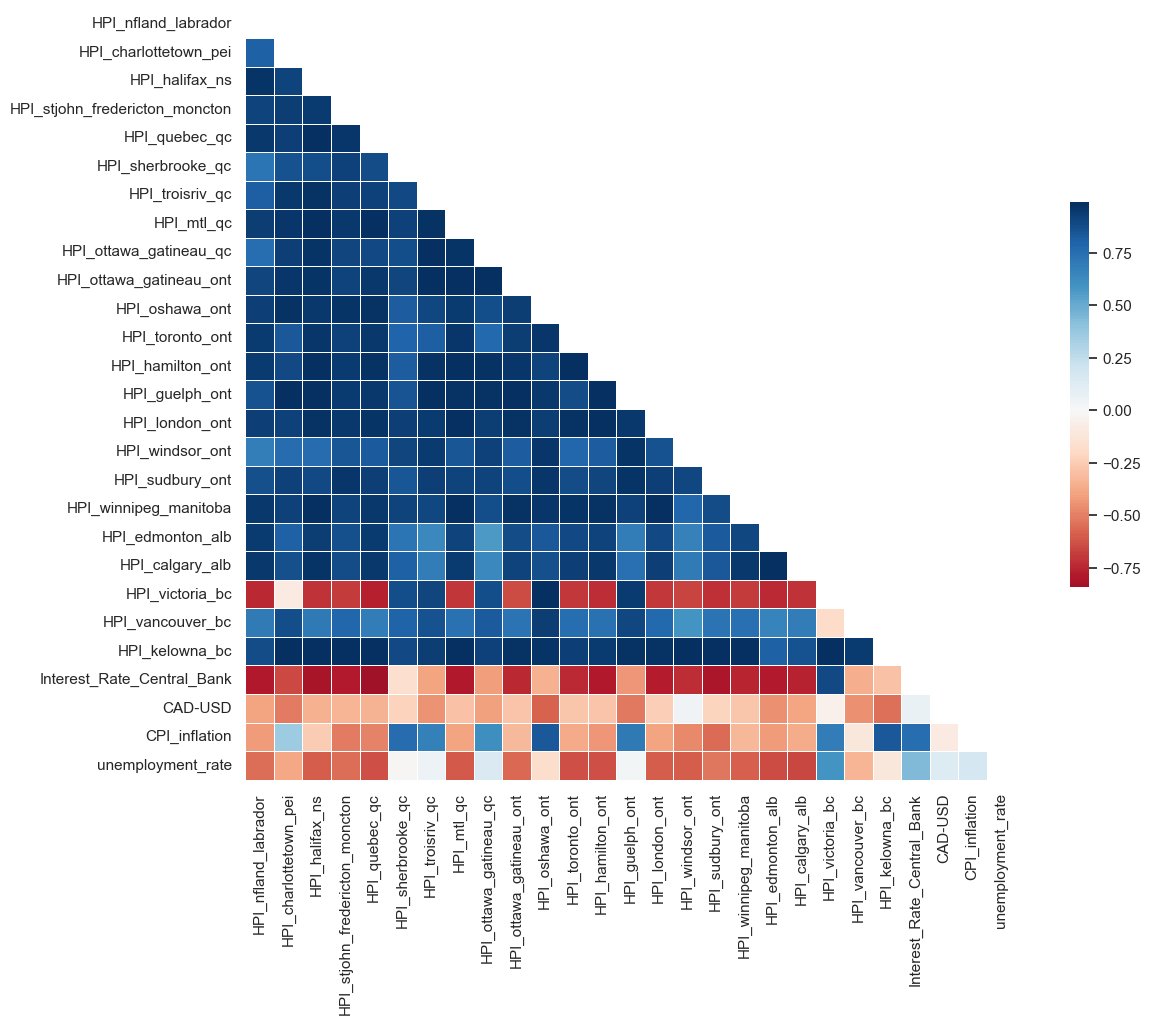

In [55]:
#Visualizing the Correlation Matrix with colors, HeatMap, showing the strength
mask = np.triu(np.ones_like(corr, dtype = np.bool))

f, ax = plt.subplots(figsize=(14,10))

#Heatmap colors
cmap = "RdBu"

sns.heatmap(
    corr,
    mask = mask,
    cmap = cmap,
    center = 0,
    square = True,
    linewidths = 0.5, 
    cbar_kws ={"shrink": 0.5},
)

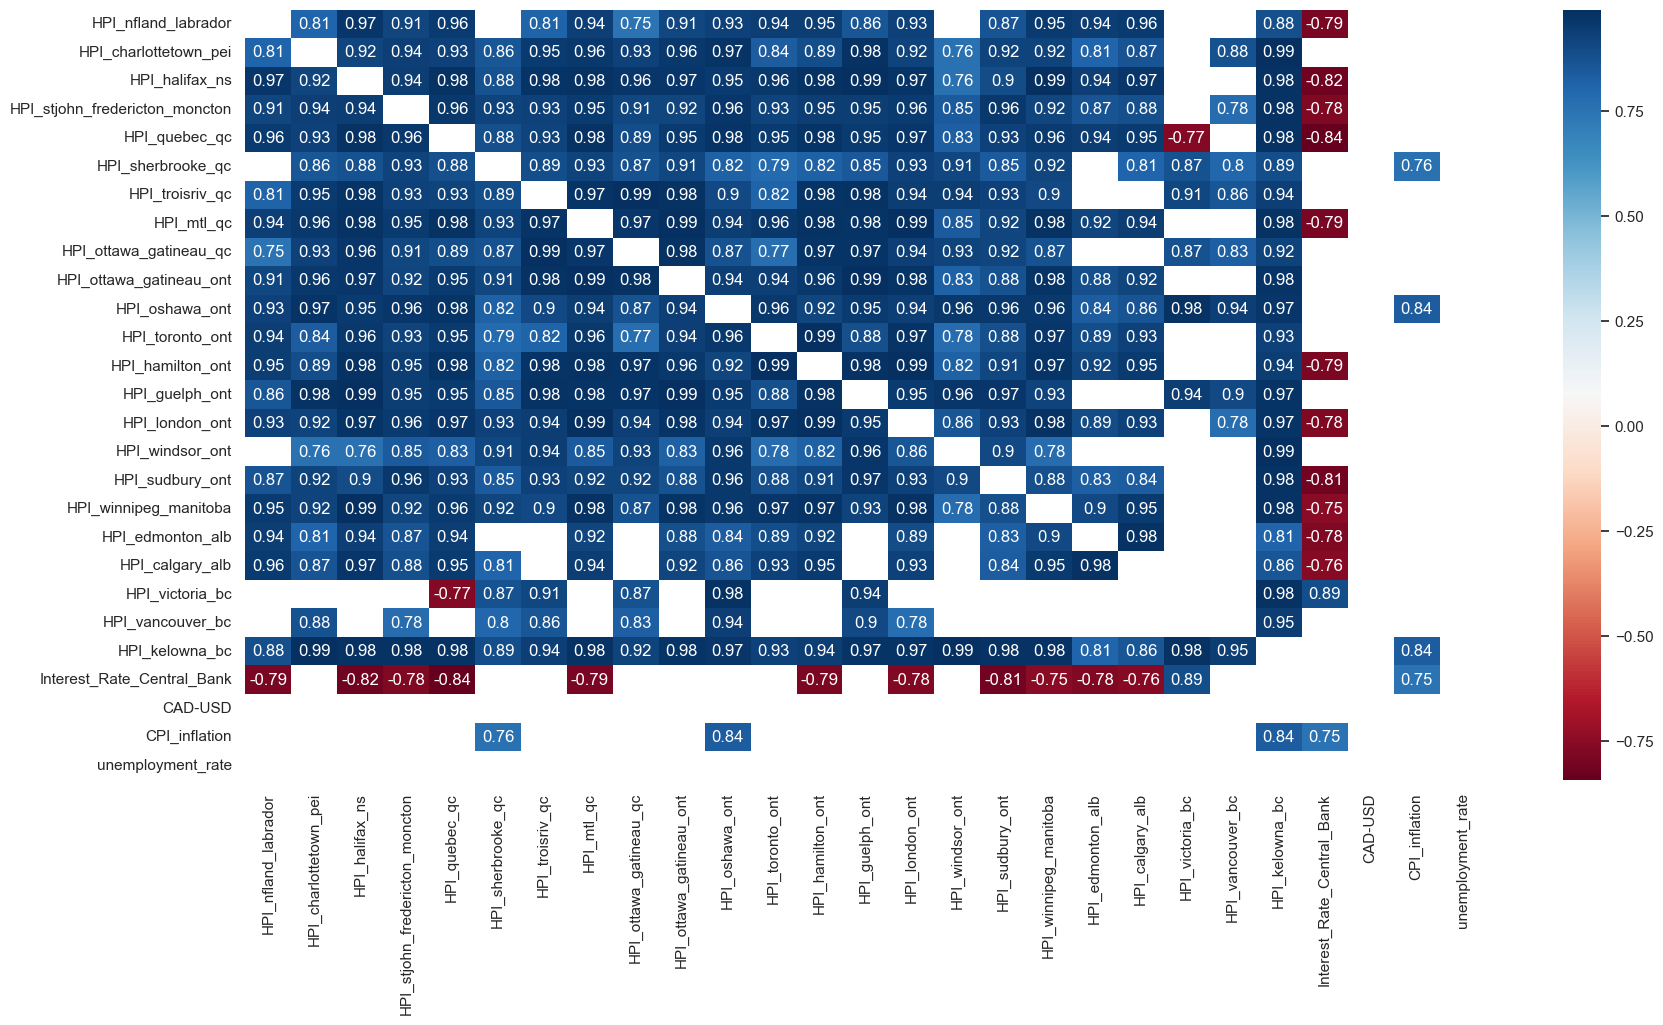

In [56]:
#Filtering values in our correlation Matrix
 
dfCorr = hpi_and_economydata_df.corr()
filteredDf = dfCorr[((dfCorr >= .75) | (dfCorr <= -.75)) & (dfCorr !=1.000)]
plt.figure(figsize=(20,10))
sns.heatmap(filteredDf, annot=True, cmap="RdBu")
plt.show()